In [1]:
import warnings
import pandas as pd
from itertools import cycle
import gpflow
import numpy as np
from scipy import linalg
from gpflow.utilities import print_summary, positive
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import namedtuple
import statsmodels.api as sm
import timeit

sns.set(style="white")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

np.random.seed(123)

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_summary_fmt("notebook")

<ipython-input-1-c790307d65ce>:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from gpflow.monitor import (
    ImageToTensorBoard,
    ModelToTensorBoard,
    Monitor,
    MonitorTaskGroup,
    ScalarToTensorBoard,
)

In [4]:
def country_selection(country_name, loc_mobility=None, loc_covid=None, print_summary=True, plots=True):
    
    avaliable_countries = ["Germany", "Japan", "Australia", "Canada", 
                          "United States", "South Korea", "Italy", "Argentina", 
                          "Turkey", "Thailand", "Colombia", "Mexico",
                          "India", "Kenya", "Bolivia", "Egypt"]
    
    if country_name not in avaliable_countries:
        warnings.warn("The selected country might not have optimal COVID data.")
    else:
        # https://en.wikipedia.org/wiki/List_of_countries_by_inequality-adjusted_HDI
        if country_name in ["Germany", "Japan", "Australia", "Canada"]:
            # Tier 1: 0.800–1.000 (very high)
            tier = 1         
        elif country_name in ["United States", "South Korea", "Italy", "Argentina"]:
            # Tier 2: 0.700–0.799 (high)
            tier = 2
        elif country_name in ["Turkey", "Thailand", "Algeria", "Mexico"]:
            # Tier 3: 0.550–0.699 (medium)
            tier = 3
        else:
            # Tier 4: 0.350–0.549 (low)
            tier = 4
            
    if loc_mobility==None:
        loc_mobility="./Data/Google/Global_Mobility_Report.csv"
        
    mobility_data = pd.read_csv(loc_mobility, 
                                encoding="ISO-8859-1", 
                                parse_dates=["date"],
                                dayfirst=True, low_memory=False)
    
    mobility_data = mobility_data[
        (mobility_data["country_region"]==country_name) & 
        (mobility_data["sub_region_1"].isnull()) & 
        (mobility_data["metro_area"].isnull())]
    mobility_data = mobility_data.iloc[:,7:].reset_index(drop=True) # keep only relevant columns
    mobility_data.iloc[:,1:] = mobility_data.iloc[:,1:].apply(lambda x: x/100 + 1)
    
    mobility_data = pd.DataFrame({
        "date": mobility_data["date"],
        "HOME": mobility_data['residential_percent_change_from_baseline'],
        "WORK": mobility_data['workplaces_percent_change_from_baseline'],
        "RECREATIONAL": mobility_data['retail_and_recreation_percent_change_from_baseline'],
        "OTHER": mobility_data.iloc[:,2:5].mean(axis=1)
    })
    
    if loc_covid==None:
        loc_covid="./Data/Microsoft/COVID_CASES.csv"
     # COVID Cases from Microsoft, includes Recovered and Infected
    ms_covid = pd.read_csv(loc_covid, 
                           encoding="ISO-8859-1",
                           parse_dates=["Updated"],
                           dayfirst=False, low_memory=False)
    
    ms_covid = ms_covid[(ms_covid["Country_Region"]==country_name) & (ms_covid["AdminRegion1"].isnull())]
    ms_covid = ms_covid.loc[:,["Updated", "Confirmed", "ConfirmedChange", "Deaths", "Recovered"]]   
    
    # Create the 3 categories S, I, R for US data (UK does not include R)
    ms_covid = ms_covid.fillna(method='ffill').fillna(0)

    # DIFF: Instead of smoothing the I, Daily cases and S, ammend the problematic R value @ 2020-07-18
    # To match the next 2020-07-19
    if country_name=="United States":
        ms_covid.iloc[178, 4] = 1117084.0
        
    # Read the countries population from World Bank Database 2019
    pop_dt = pd.read_excel(
        "./Data/Population/Data_Extract_From_World_Development_Indicators.xls")
    

    population_size = pop_dt.loc[pop_dt.CountryName==country_name, "Total"].values[0]
    
    ms_covid["I"] = ms_covid["Confirmed"] - ms_covid["Deaths"] - ms_covid["Recovered"]
    ms_covid.drop(["Confirmed", "Deaths", "Recovered"], axis=1, inplace=True)
    ms_covid["S"] = population_size - ms_covid["I"]
    ms_covid["index"] = ms_covid["Updated"].dt.dayofyear

    # DIFF: Create a time variable
    # If we have a weekend then assign 0 or weekday 1
    ms_covid["WEEKDAY"] = (ms_covid["Updated"].dt.dayofweek < 5).astype(int)
    
    ms_covid["ConfirmedChange"] = np.log(ms_covid["ConfirmedChange"].rolling(7).median()+1)
    ms_covid["I"] = ms_covid["I"].rolling(7).median()
    ms_covid["S"] = ms_covid["S"].rolling(7).median()

    ms_covid.dropna(inplace=True)
    ms_covid.reset_index(drop=True, inplace=True)
    
    final_data = ms_covid.set_index("Updated").merge(
    mobility_data.set_index("date"), how='left', left_index=True, right_index=True).reset_index()
    final_data.dropna(inplace=True)
    final_data.reset_index(drop=True, inplace=True)
    final_data.columns.values[0] = "Updated"
    
    if plots:
        
        fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 4))
        fig.suptitle("{0} is a Tier {1} country in IHDI".format(country_name, int(tier)), fontsize=16)
        final_data.set_index("Updated")[["ConfirmedChange"]].plot(ax=axs[0, 0])
        final_data.set_index("Updated")[["I"]].plot(ax=axs[0, 1])
        final_data.set_index("Updated")[["S"]].plot(ax=axs[0, 2])
        final_data.set_index("Updated")[["HOME"]].plot(ax=axs[1, 0])
        final_data.set_index("Updated")[["WORK"]].plot(ax=axs[1, 1])
        final_data.set_index("Updated")[["OTHER"]].plot(ax=axs[1, 2])
    
    if print_summary:
        print(round(final_data.describe(), 3))
    
    return(final_data)

In [5]:
def create_multioutput_table(long=False):
    
    countries_list = ["Germany", "Japan", "Australia", "Canada", 
                      "United States", "South Korea", "Italy", "Argentina", 
                      "Turkey", "Thailand", "Colombia", "Mexico",
                      "India", "Kenya", "Bolivia", "Egypt"]
    
    if long: # Long table format. We create a column to name each country and we concat the tables.
        for i, country_name in enumerate(countries_list):

            print("\n Read {0} and extract the data...{1}".format(country_name, i))

            if i==0:
                final_data = country_selection(country_name, print_summary=False, plots=False)
                final_data["Country"] = country_name
            else:
                data_batch = country_selection(country_name, print_summary=False, plots=False)
                data_batch["Country"] = country_name
                final_data = pd.concat([final_data, data_batch], axis=0)
            
    else: # We add each country's table as a column extension. We add a suffix on each column country-group.
        for i, country_name in enumerate(countries_list):
            
            print("\n Read {0} and extract the data...{1}".format(country_name, i))
            
            if i==0:
                final_data = country_selection(country_name, print_summary=False, plots=False)
                final_data.columns = [str(col) + '_' + str(country_name) for col in final_data.columns]
            else:    
                data_batch = country_selection(country_name, print_summary=False, plots=False)
                data_batch.columns = [str(col) + '_' + str(country_name) for col in data_batch.columns]
                final_data = pd.concat([final_data, data_batch], axis=1)

        
    return(final_data) 

In [6]:
final_data = create_multioutput_table()


 Read Germany and extract the data...0

 Read Japan and extract the data...1

 Read Australia and extract the data...2

 Read Canada and extract the data...3

 Read United States and extract the data...4

 Read South Korea and extract the data...5

 Read Italy and extract the data...6

 Read Argentina and extract the data...7

 Read Turkey and extract the data...8

 Read Thailand and extract the data...9

 Read Colombia and extract the data...10

 Read Mexico and extract the data...11

 Read India and extract the data...12

 Read Kenya and extract the data...13

 Read Bolivia and extract the data...14

 Read Egypt and extract the data...15


In [7]:
final_data.shape

(164, 160)

## Data Preprocessing (similar to the experiment.py)

I will not create a class for that since we wish to check a very specific task.
The GP model that I will use is going to be the 

In [8]:
# Drop rows with missing values
# In this particular example are going to be 20-30 bottom rows. 
final_data.dropna(axis=0, inplace=True)

In [7]:
# Split the dataset
y = final_data.filter(regex='^ConfirmedChange', axis=1).to_numpy() # Extract columns that contain each country's daily COVID cases
y_cols = final_data.filter(regex='^ConfirmedChange', axis=1).columns


X = final_data.drop(final_data.filter(regex='^Updated|^Confirmed', axis=1).columns, axis=1).to_numpy() # Extract mobility and SI data for each country
X_cols = final_data.drop(final_data.filter(regex='^Updated|^Confirmed', axis=1).columns, axis=1).columns

X_train, X_test = X[:-21,:], X[-21:,:]
y_train, y_test = y[:-21,:], y[-21:,:]

y_scaler = preprocessing.StandardScaler().fit(y_train)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)
#y = y_scaler.transform(y)

x_scaler = preprocessing.StandardScaler().fit(X_train)
X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)
#X = x_scaler.transform(X)

In [8]:
X_cols[list(range(0, 8))]

Index(['I_Germany', 'S_Germany', 'index_Germany', 'WEEKDAY_Germany',
       'HOME_Germany', 'WORK_Germany', 'RECREATIONAL_Germany',
       'OTHER_Germany'],
      dtype='object')

In [9]:
print("The shape of y is: {0} and the shape of X is: {1}".format(y.shape, X.shape))
print("The shape of X_train is: {0} and the shape of X_test is: {1}".format(X_train.shape, X_test.shape))

The shape of y is: (131, 16) and the shape of X is: (131, 128)
The shape of X_train is: (110, 128) and the shape of X_test is: (21, 128)


In [10]:
countries_list = ["Germany", "Japan", "Australia", "Canada",
                  "United States", "South Korea", "Italy", "Argentina", 
                  "Turkey", "Thailand", "Colombia", "Mexico",
                  "India", "Kenya", "Bolivia", "Egypt"]

In [19]:
# Set the parameters of the model, kernels, inducing points, number of outputs.
P = len(y_cols)

# Create list of kernels for each output
# Each country has 8 covariates, I, S, t, weekday, mobility
kern_list = [gpflow.kernels.SquaredExponential(lengthscales=np.ones(8), active_dims=list(range(_, _+8))) * \
             gpflow.kernels.Linear(active_dims=list(range(_, _+8))) *  \
             gpflow.kernels.RationalQuadratic(lengthscales=np.ones(8), active_dims=list(range(_, _+8))) for _ in range(P)]
# Create multi-output kernel from kernel list
kernel = gpflow.kernels.SeparateIndependent(kern_list)

Zinit = X_train[np.random.randint(X_train.shape[0], size=15), :]
# initialization of inducing input locations, one set of locations per output
Zs = [Zinit.copy() for _ in range(P)]
# initialize as list inducing inducing variables
iv_list = [gpflow.inducing_variables.InducingPoints(Z) for Z in Zs]
# create multi-output inducing variables from iv_list
iv = gpflow.inducing_variables.SeparateIndependentInducingVariables(iv_list)

In [20]:
# create SVGP model
m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=P)

In [21]:
#print_summary(m)

In [22]:
# Use natural gradients to optimise the variational parameters
set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

# use Adam to optimise the kernel parameters
adam_opt = tf.optimizers.Adam(0.01)
natgrad_opt = NaturalGradient(gamma=0.1)

variational_params = [(m.q_mu, m.q_sqrt)]

train_loss = m.training_loss_closure((X_train, y_train))

In [36]:
logf = []
length1 = []
length2 = []
rmse = []
tr_bias = []
tr_var = []
test_rmse = []
tst_bias = []
tst_var = []
complexity = []

for _ in range(ci_niter(1000)):
    natgrad_opt.minimize(train_loss, var_list=variational_params)
    adam_opt.minimize(train_loss, var_list=m.trainable_variables)
    elbo = -train_loss().numpy()
    logf.append(elbo)
        
    # Model complexity
    complexity.append(np.sum(-0.5*tf.linalg.logdet(kernel(X_train))))
    
    # For this particular kernel we take Germany [0], Squared Exp ARD [0] and the I [0] and recreational [6] lengthscales
    length1.append(m.kernel.kernels[0].kernels[0].lengthscales[0].numpy())
    length2.append(m.kernel.kernels[0].kernels[0].lengthscales[6].numpy())
    
    # Training error
    mean_predict, _ = m.predict_y(X_train)
    rmse.append(np.sqrt(np.mean((y_train - mean_predict)**2)))
    
    # Training bias-variance
    tr_bias.append(np.sqrt(np.mean((y_train - np.mean(mean_predict, axis=0))**2)))
    tr_var.append(np.sqrt(np.mean((mean_predict - np.mean(mean_predict, axis=0))**2)))
    
    # Test error
    mean_predict, _ = m.predict_y(X_test)
    test_rmse.append(np.sqrt(np.mean((y_test - mean_predict)**2)))
    
    # Test bias-variance
    tst_bias.append(np.sqrt(np.mean((y_test - np.mean(mean_predict, axis=0))**2)))
    tst_var.append(np.sqrt(np.mean((mean_predict - np.mean(mean_predict, axis=0))**2)))  

    
logf = np.array(logf)
length1 = np.array(length1)
length2 = np.array(length2)
rmse = np.array(rmse)
tr_bias = np.array(tr_bias)
tr_var = np.array(tr_var)
test_rmse = np.array(test_rmse)
tst_bias = np.array(tst_bias)
tst_var = np.array(tst_var)
complexity = np.array(complexity)

Text(0.5, 0.92, 'Germany, Squared Exponential Kernel')

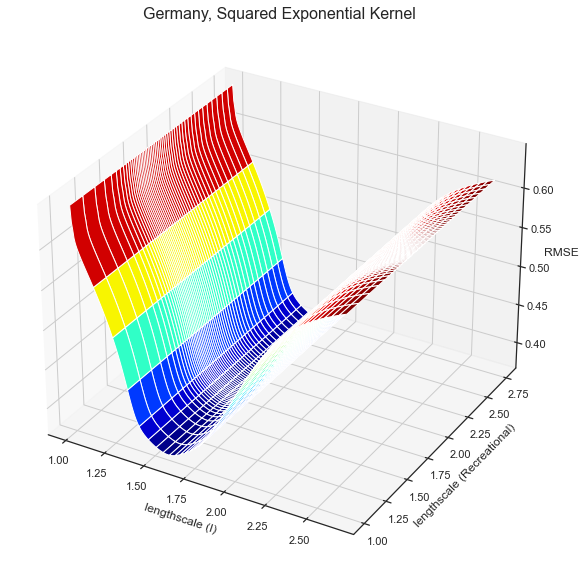

In [37]:
# Try to plot a 3D figure of a SE lengthscale of infected, a SE lengthscale of recreational, of the training set RMSE
# over 1000 optimization iterations.
xaxis, yaxis = np.meshgrid(length1, length2)
zaxis, yaxis = np.meshgrid(rmse, length2)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xaxis, yaxis, zaxis, cmap='jet')
ax.set_xlabel('lengthscale (I)')
ax.set_ylabel('lengthscale (Recreational)')
ax.set_zlabel('RMSE')
ax.set_title('Germany, Squared Exponential Kernel', fontsize=16)

Text(0.5, 1.0, 'Variance of the training data')

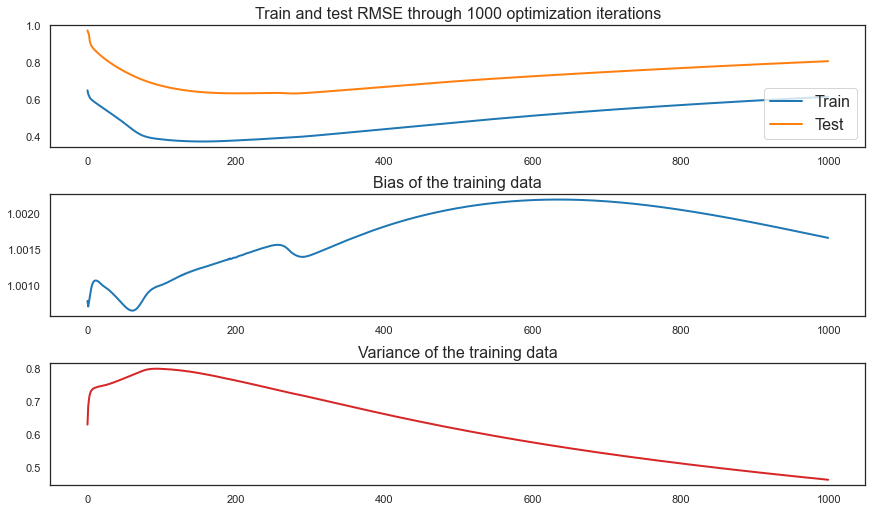

In [39]:
# Plot the evolution of train and test RMSE through the 1000 optimization iterations
fig = plt.figure(constrained_layout=True, figsize=(12, 7))
spec = GridSpec(ncols=1, nrows=3, figure=fig)
ax0 = fig.add_subplot(spec[0, 0])
ax0.plot(rmse, color='tab:blue', label='Train', linewidth=2)
ax0.plot(test_rmse, color='tab:orange', label='Test', linewidth=2)
#ax0.axvline(x=np.where(rmse == rmse.min()), color='red')
ax0.legend(loc='lower right', fontsize=16)
ax0.set_title('Train and test RMSE through 1000 optimization iterations', fontsize=16)

ax1 = fig.add_subplot(spec[1, 0])
ax1.plot(tr_bias, color='tab:blue', label='Bias', linewidth=2)
ax1.set_title('Bias of the training data', fontsize=16)

ax2 = fig.add_subplot(spec[2, 0])
ax2.plot(tr_var, color='tab:red', label='Variance', linewidth=2)
ax2.set_title('Variance of the training data', fontsize=16)

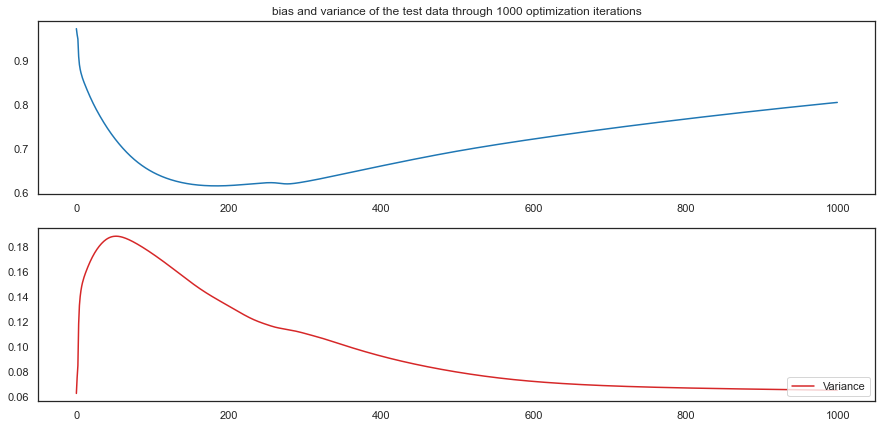

In [40]:
# Plot the evolution of bias and variance in the test set through the 1000 optimization iterations
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 7))
ax[0].plot(np.array(tst_bias), color='tab:blue', label='Bias')
ax[0].set_title('bias and variance of the test data through 1000 optimization iterations')
ax[1].plot(np.array(tst_var), color='tab:red', label='Variance')
plt.legend(loc='lower right')

In [41]:
# Train predictions
mean_train, var_train = m.predict_y(X_train)

In [42]:
# Test predictions
mean_test, var_test = m.predict_y(X_test)

In [43]:
# Full predictions (train + test)
# using the trained based normalisation (x_scaler)
mean, var = m.predict_y(x_scaler.transform(X))
_y = y_scaler.transform(y)

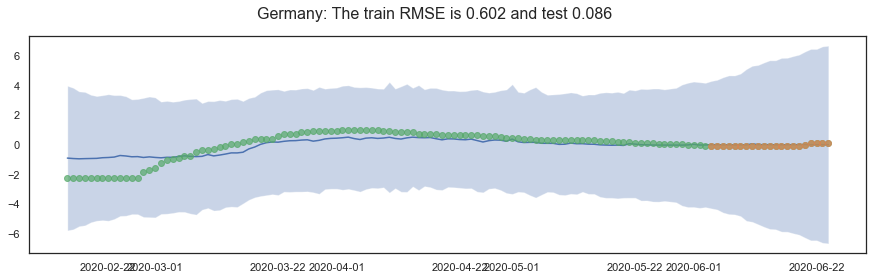

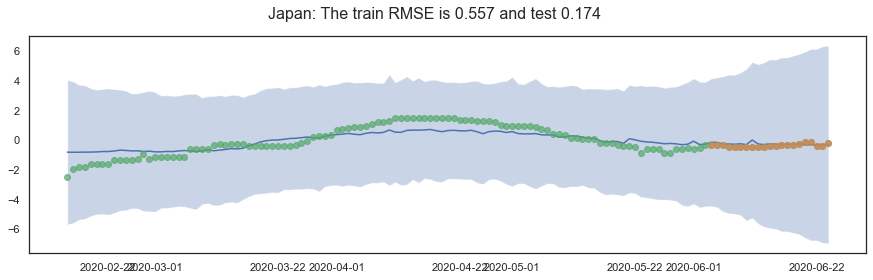

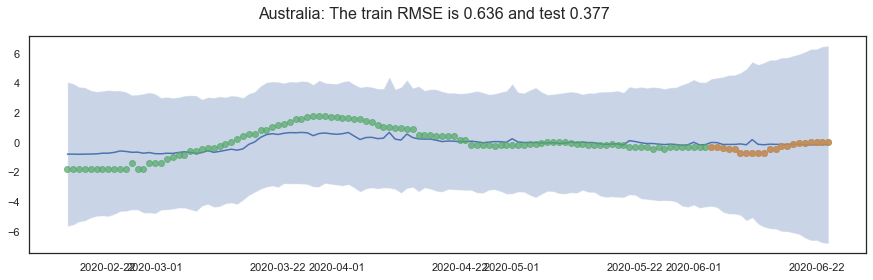

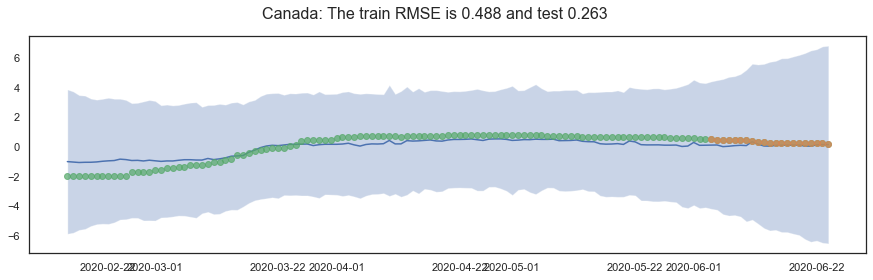

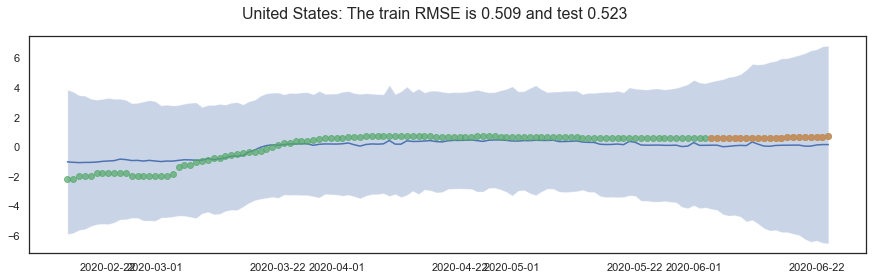

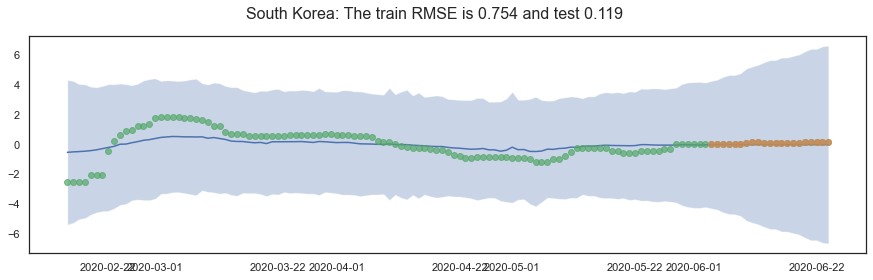

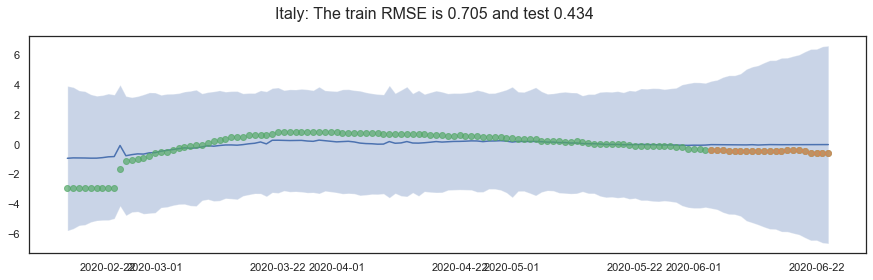

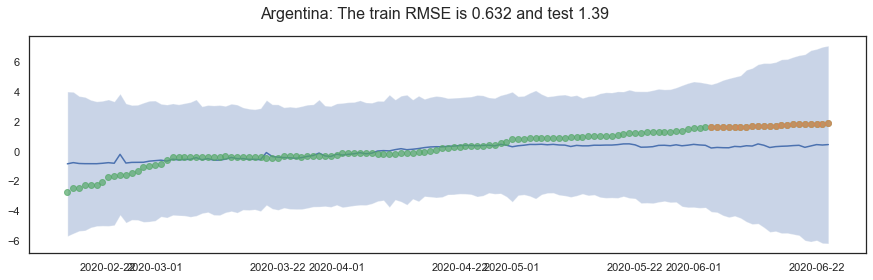

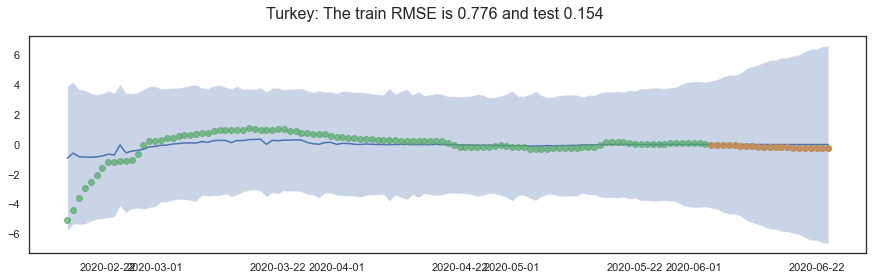

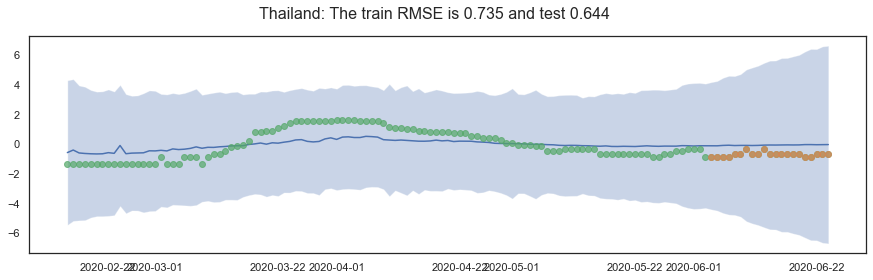

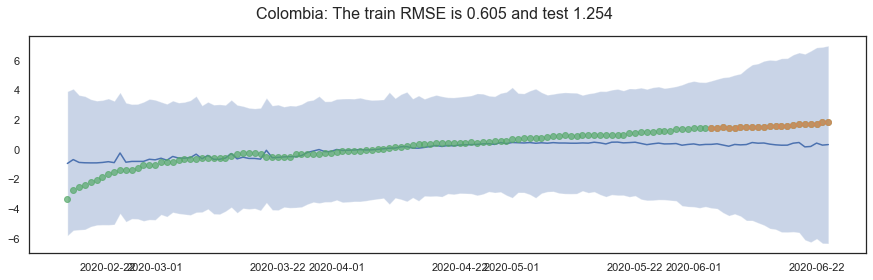

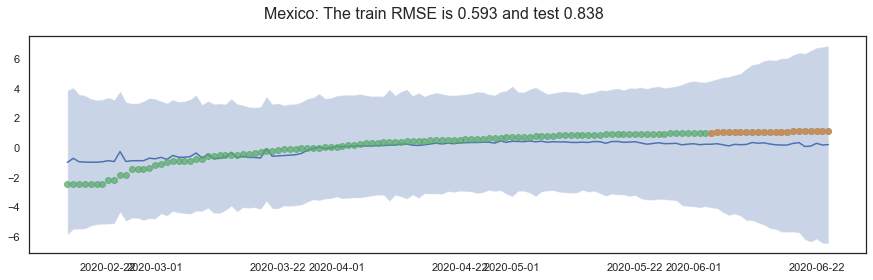

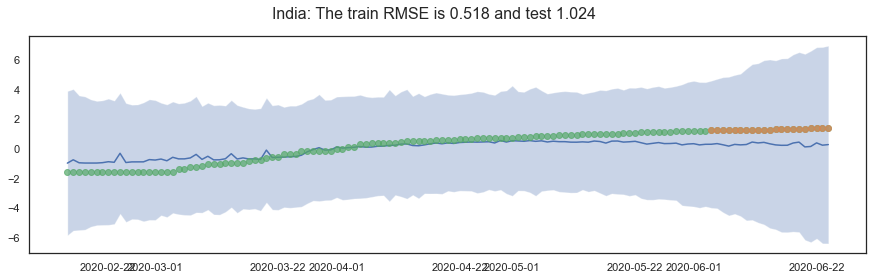

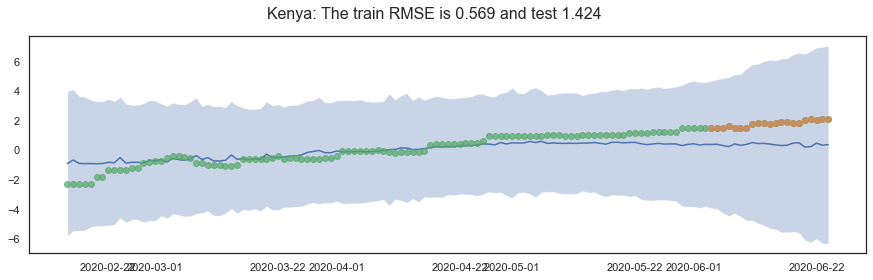

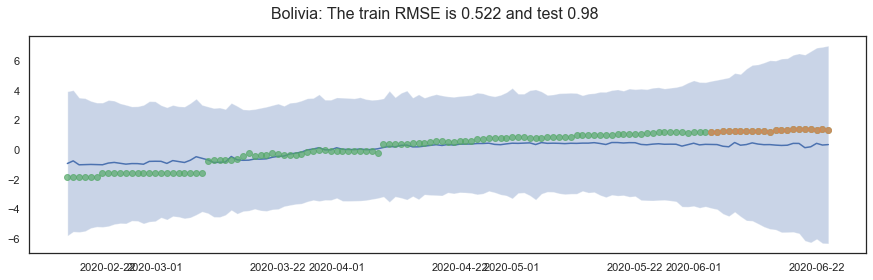

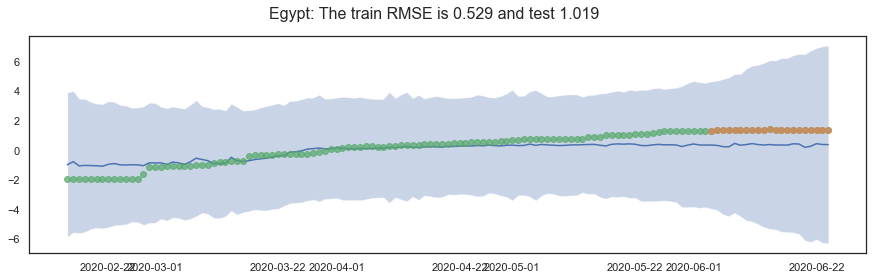

In [44]:
t = final_data[["Updated_Germany"]].to_numpy()

for c, country in enumerate(countries_list):
    
    train_error = np.sqrt(np.mean((y_train[:, c] - mean_train[:, c])**2))
    test_error = np.sqrt(np.mean((y_test[:, c] - mean_test[:, c])**2))
    
    _fig, ax = plt.subplots(1, figsize=(15, 4))
    
    _fig.suptitle("{0}: The train RMSE is {1} and test {2}".format(country, np.round(train_error, 3), 
                                                                   np.round(test_error, 3)), fontsize=16)
    ax.plot(t, mean[:, c], "-", c="C0")
    lo = (mean[:, c] - 2 * tf.sqrt(var[:, c])).numpy()
    hi = (mean[:, c] + 2 * tf.sqrt(var[:, c])).numpy()
    ax.fill_between(t.flatten(), lo.flatten(), hi.flatten(), alpha=0.3)
    ax.plot(t, _y[:, c], "o", c="C2", alpha=0.7, label="train")
    ax.plot(t[-21:, :], _y[-21:, c], "o", c="C1", alpha=0.7, label="test")

## Single output model

In [9]:
final_data_US = create_multioutput_table(long=True)


 Read Germany and extract the data...0

 Read Japan and extract the data...1

 Read Australia and extract the data...2

 Read Canada and extract the data...3

 Read United States and extract the data...4

 Read South Korea and extract the data...5

 Read Italy and extract the data...6

 Read Argentina and extract the data...7

 Read Turkey and extract the data...8

 Read Thailand and extract the data...9

 Read Colombia and extract the data...10

 Read Mexico and extract the data...11

 Read India and extract the data...12

 Read Kenya and extract the data...13

 Read Bolivia and extract the data...14

 Read Egypt and extract the data...15


In [10]:
final_data_US = final_data_US[final_data_US.Country=="United States"]

In [11]:
final_data_US.drop(["Country"], axis=1, inplace=True)

In [12]:
final_data.Updated_Germany

0     2020-02-15
1     2020-02-16
2     2020-02-17
3     2020-02-18
4     2020-02-19
         ...    
126   2020-06-20
127   2020-06-21
128   2020-06-22
129   2020-06-23
130   2020-06-24
Name: Updated_Germany, Length: 131, dtype: datetime64[ns]

In [13]:
final_data_US = final_data_US[final_data_US.Updated<="2020-06-24"] # To be consistent with the multioutput

In [14]:
final_data_US.columns

Index(['Updated', 'ConfirmedChange', 'I', 'S', 'index', 'WEEKDAY', 'HOME',
       'WORK', 'RECREATIONAL', 'OTHER'],
      dtype='object')

In [43]:
# Split the dataset
y = final_data_US[["ConfirmedChange"]].to_numpy() 


X = final_data_US[['I', 'S', 'index', 'WEEKDAY', 'HOME',
       'WORK', 'RECREATIONAL', 'OTHER']].to_numpy() 

X_train, X_test = X[:-21,:], X[-21:,:]
y_train, y_test = y[:-21,:], y[-21:,:]

y_scaler = preprocessing.StandardScaler().fit(y_train)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)
#y = y_scaler.transform(y)

x_scaler = preprocessing.StandardScaler().fit(X_train)
X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)
#X = x_scaler.transform(X)

In [44]:
kernel = gpflow.kernels.SquaredExponential(lengthscales=np.ones(X.shape[1])) * \
        gpflow.kernels.Linear() * \
        gpflow.kernels.RationalQuadratic(lengthscales=np.ones(X.shape[1]))

Zinit = X_train[np.random.randint(X_train.shape[0], size=15), :]



In [45]:
# create SVGP model
m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), inducing_variable=Zinit)

In [46]:
def plot_prediction(fig, ax):
    # Full predictions (train + test)
    mean, var = m.predict_y(x_scaler.transform(X))
    _y = y_scaler.transform(y)
    Ypred = m.predict_f_samples(x_scaler.transform(X), full_cov=True, num_samples=20)

    t = final_data_US[["Updated"]].to_numpy()

    _fig, ax = plt.subplots(1, figsize=(15, 4))

    ax.plot(t, np.squeeze(Ypred).T, "C3", alpha=0.2)
    ax.plot(t, mean, "-", c="C0")
    lo = (mean - 2 * tf.sqrt(var)).numpy()
    hi = (mean + 2 * tf.sqrt(var)).numpy()
    ax.fill_between(t.flatten(), lo.flatten(), hi.flatten(), alpha=0.3)
    ax.plot(t, _y, "o", c="C2", alpha=0.7, label="train")
    ax.plot(t[-21:], _y[-21:], "o", c="C1", alpha=0.7, label="test")

In [47]:
# Monitor Optimization TF 
log_dir = "logs"  # Directory where TensorBoard files will be written.
model_task = ModelToTensorBoard(log_dir, m)
image_task = ImageToTensorBoard(log_dir, plot_prediction, "image_samples")
lml_task = ScalarToTensorBoard(log_dir, lambda: m.training_loss((X_train, y_train)), "training_objective")

In [48]:
# Plotting tasks can be quite slow. We want to run them less frequently.
# We group them in a `MonitorTaskGroup` and set the period to 5.
slow_tasks = MonitorTaskGroup(image_task, period=100)

# The other tasks are fast. We run them at each iteration of the optimisation.
fast_tasks = MonitorTaskGroup([model_task, lml_task], period=1)

# Both groups are passed to the monitor.
# `slow_tasks` will be run five times less frequently than `fast_tasks`.
monitor = Monitor(fast_tasks, slow_tasks)

In [49]:
# Use natural gradients to optimise the variational parameters
set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

# use Adam to optimise the kernel parameters
adam_opt = tf.optimizers.Adam(0.01)
natgrad_opt = NaturalGradient(gamma=0.1)

variational_params = [(m.q_mu, m.q_sqrt)]

train_loss = m.training_loss_closure((X_train, y_train))

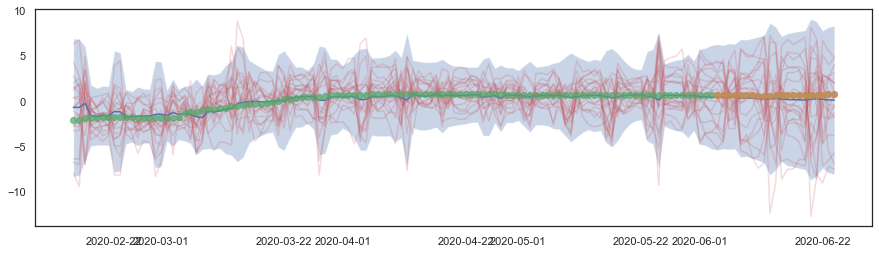

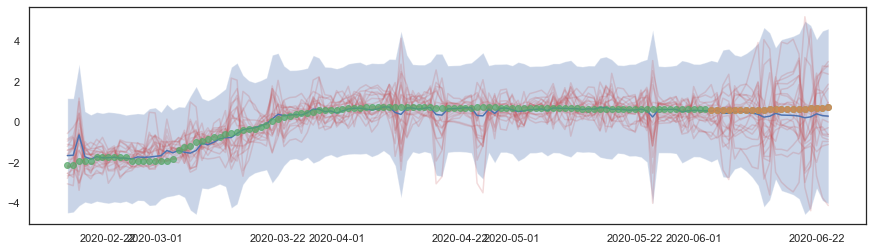

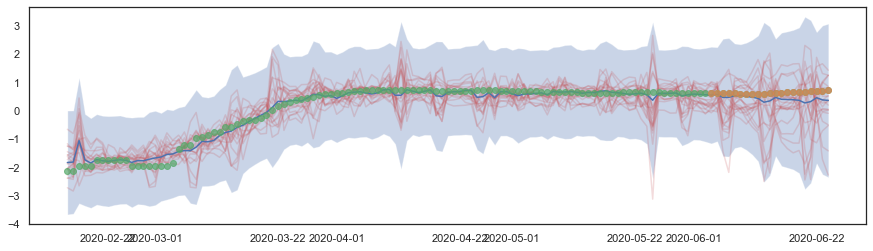

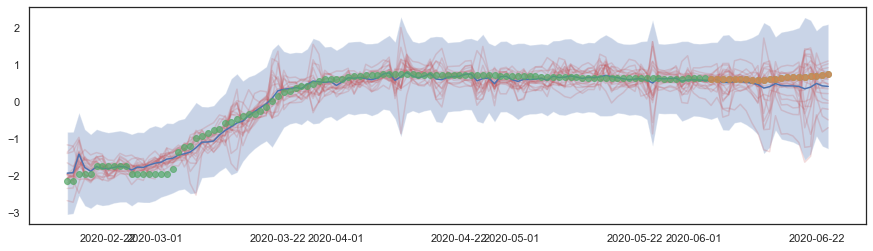

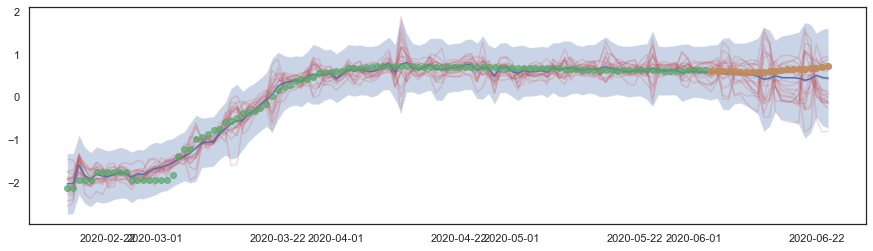

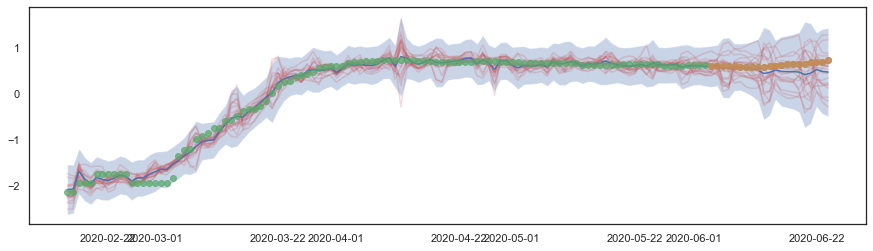

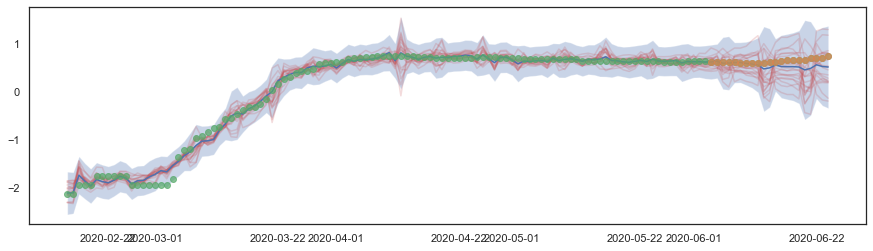

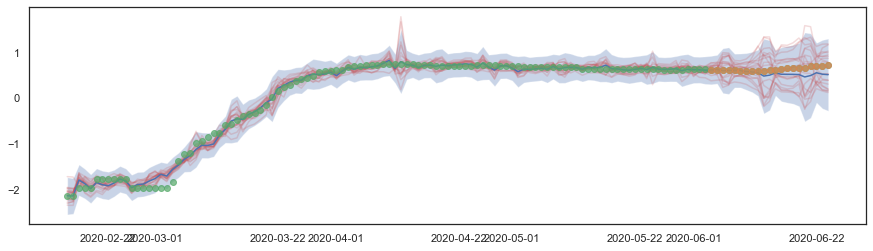

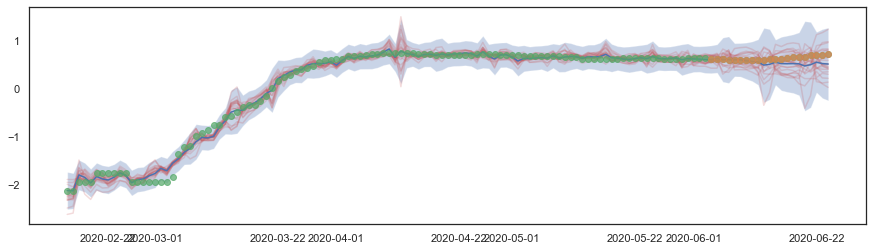

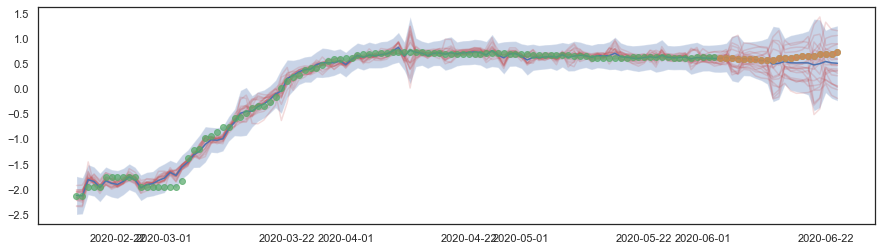

In [50]:
for _ in range(ci_niter(1000)):
    natgrad_opt.minimize(train_loss, var_list=variational_params)
    adam_opt.minimize(train_loss, var_list=m.trainable_variables)
    monitor(_)
    

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [55]:
logf_sop = []
length1_sop = []
length2_sop = []
rmse_sop = []
tr_bias_sop = []
tr_var_sop = []
test_rmse_sop = []
tst_bias_sop = []
tst_var_sop = []
complexity_sop = []

for _ in range(ci_niter(1000)):
    natgrad_opt.minimize(train_loss, var_list=variational_params)
    adam_opt.minimize(train_loss, var_list=m.trainable_variables)
    elbo = -train_loss().numpy()
    logf_sop.append(elbo)
    
    # Model complexity
    complexity_sop.append(np.sum(-0.5*tf.linalg.logdet(kernel(X_train))))
    
    # For this particular kernel we take Squared Exp ARD [0] and the infected [0] and recreational [6] lengthscales
    length1_sop.append(m.kernel.kernels[0].lengthscales[0].numpy())
    length2_sop.append(m.kernel.kernels[0].lengthscales[6].numpy())
    
    # Train error
    mean_predict, _ = m.predict_y(X_train)
    rmse_sop.append(np.sqrt(np.mean((y_train - mean_predict)**2)))
    
    # Training bias-variance
    tr_bias_sop.append(np.sqrt(np.mean((y_train - np.mean(mean_predict))**2)))
    tr_var_sop.append(np.sqrt(np.mean((mean_predict - np.mean(mean_predict))**2)))
    
    # Test error
    mean_predict, _ = m.predict_y(X_test)
    test_rmse_sop.append(np.sqrt(np.mean((y_test - mean_predict)**2)))
    
    # Test bias-variance
    tst_bias_sop.append(np.sqrt(np.mean((y_test - np.mean(mean_predict))**2)))
    tst_var_sop.append(np.sqrt(np.mean((mean_predict - np.mean(mean_predict))**2))) 
    

logf_sop = np.array(logf_sop)
length1_sop = np.array(length1_sop)
length2_sop = np.array(length2_sop)
rmse_sop = np.array(rmse_sop)
tr_bias_sop = np.array(tr_bias_sop)
tr_var_sop = np.array(tr_var_sop)
test_rmse_sop = np.array(test_rmse_sop)
tst_bias_sop = np.array(tst_bias_sop)
tst_var_sop = np.array(tst_var_sop)
complexity_sop = np.array(complexity_sop)

Text(0.5, 0.92, 'US, Squared Exponential Kernel')

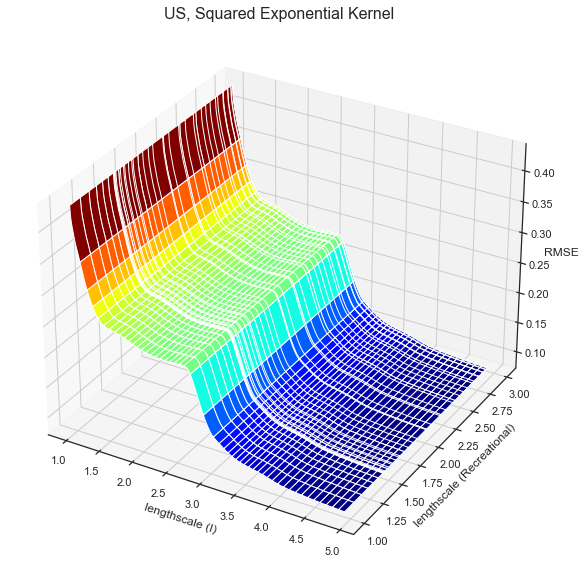

In [63]:
# Try to plot a 3D figure of a SE lengthscale of infected, a SE lengthscale of recreational, of the training set RMSE
# over 1000 optimization iterations.
xaxis, yaxis = np.meshgrid(length1_sop, length2_sop)
zaxis, yaxis = np.meshgrid(rmse_sop, length2_sop)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xaxis, yaxis, zaxis, cmap='jet')
ax.set_xlabel('lengthscale (I)')
ax.set_ylabel('lengthscale (Recreational)')
ax.set_zlabel('RMSE')
ax.set_title('US, Squared Exponential Kernel', fontsize=16)

Text(0.5, 1.0, 'Variance of the training data')

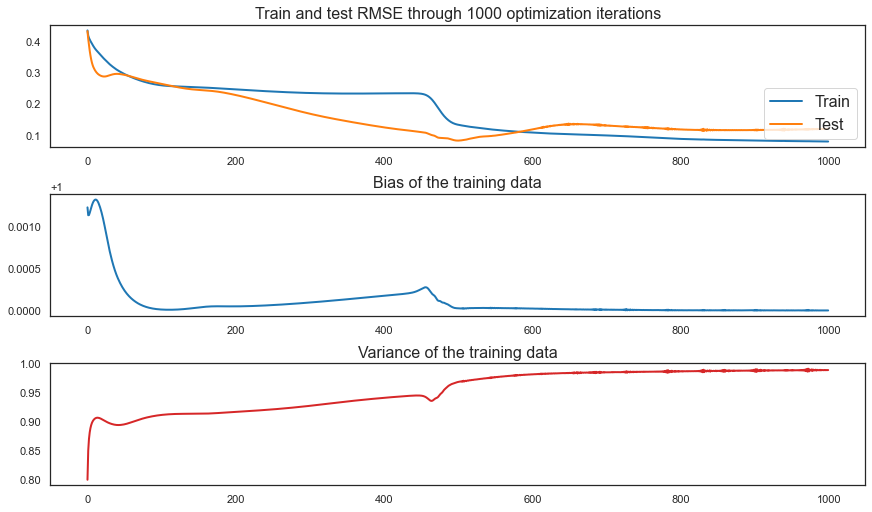

In [64]:
# Plot the evolution of train and test RMSE through the 1000 optimization iterations
fig = plt.figure(constrained_layout=True, figsize=(12, 7))
spec = GridSpec(ncols=1, nrows=3, figure=fig)
ax0 = fig.add_subplot(spec[0, 0])
ax0.plot(rmse_sop, color='tab:blue', label='Train', linewidth=2)
ax0.plot(test_rmse_sop, color='tab:orange', label='Test', linewidth=2)
#ax0.axvline(x=np.where(rmse == rmse.min()), color='red')
ax0.legend(loc='lower right', fontsize=16)
ax0.set_title('Train and test RMSE through 1000 optimization iterations', fontsize=16)

ax1 = fig.add_subplot(spec[1, 0])
ax1.plot(tr_bias_sop, color='tab:blue', label='Bias', linewidth=2)
ax1.set_title('Bias of the training data', fontsize=16)

ax2 = fig.add_subplot(spec[2, 0])
ax2.plot(tr_var_sop, color='tab:red', label='Variance', linewidth=2)
ax2.set_title('Variance of the training data', fontsize=16)

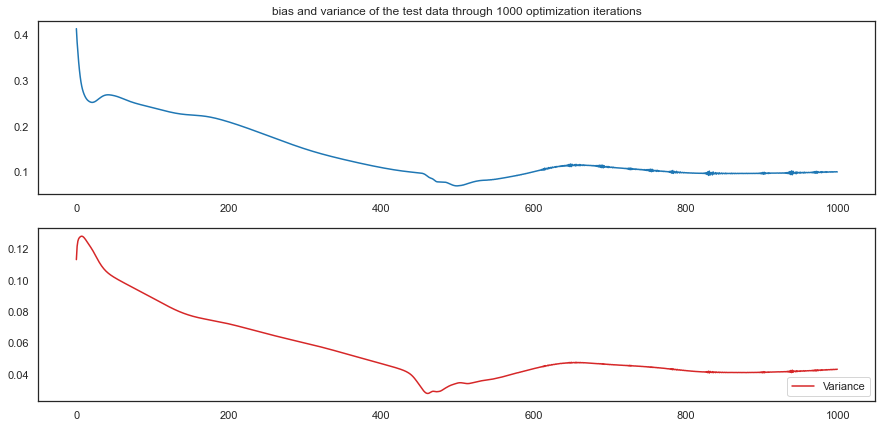

In [65]:
# Plot the evolution of bias and variance in the test set through the 1000 optimization iterations
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 7))
ax[0].plot(np.array(tst_bias_sop), color='tab:blue', label='Bias')
ax[0].set_title('bias and variance of the test data through 1000 optimization iterations')
ax[1].plot(np.array(tst_var_sop), color='tab:red', label='Variance')
plt.legend(loc='lower right')

In [66]:
# Train predictions
mean_train, var_train = m.predict_y(X_train)

In [67]:
# Test predictions
mean_test, var_test = m.predict_y(X_test)

In [68]:
# Full predictions (train + test)
mean, var = m.predict_y(x_scaler.transform(X))
_y = y_scaler.transform(y)

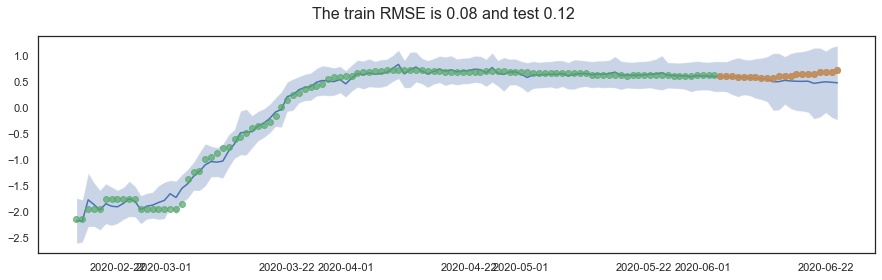

In [69]:
t = final_data_US[["Updated"]].to_numpy()
    
train_error = np.sqrt(np.mean((y_train - mean_train)**2))
test_error = np.sqrt(np.mean((y_test - mean_test)**2))
    
_fig, ax = plt.subplots(1, figsize=(15, 4))
    
_fig.suptitle("The train RMSE is {0} and test {1}".format(np.round(train_error, 3), np.round(test_error, 3)), fontsize=16)
ax.plot(t, mean, "-", c="C0")
lo = (mean - 2 * tf.sqrt(var)).numpy()
hi = (mean + 2 * tf.sqrt(var)).numpy()
ax.fill_between(t.flatten(), lo.flatten(), hi.flatten(), alpha=0.3)
ax.plot(t, _y, "o", c="C2", alpha=0.7, label="train")
ax.plot(t[-21:], _y[-21:], "o", c="C1", alpha=0.7, label="train")

## Check the Multioutput on 2-3-4 Countries and compare against the previous models. 

In [29]:
final_data = create_multioutput_table(long=False)


 Read Germany and extract the data...0

 Read Japan and extract the data...1

 Read Australia and extract the data...2

 Read Canada and extract the data...3

 Read United States and extract the data...4

 Read South Korea and extract the data...5

 Read Italy and extract the data...6

 Read Argentina and extract the data...7

 Read Turkey and extract the data...8

 Read Thailand and extract the data...9

 Read Colombia and extract the data...10

 Read Mexico and extract the data...11

 Read India and extract the data...12

 Read Kenya and extract the data...13

 Read Bolivia and extract the data...14

 Read Egypt and extract the data...15


In [30]:
#final_data = final_data.filter(regex=("Germany$|States$"), axis=1)#2 countries
final_data = final_data.filter(regex=("Germany$|States$|Turkey$"), axis=1)#3 countries

In [31]:
# Drop rows with missing values
# In this particular example are going to be 20-30 bottom rows. 
final_data.dropna(axis=0, inplace=True)

In [32]:
# Split the dataset
y = final_data.filter(regex='^ConfirmedChange', axis=1).to_numpy() # Extract columns that contain each country's daily COVID cases
y_cols = final_data.filter(regex='^ConfirmedChange', axis=1).columns


X = final_data.drop(final_data.filter(regex='^Updated|^Confirmed', axis=1).columns, axis=1).to_numpy() # Extract mobility and SI data for each country
X_cols = final_data.drop(final_data.filter(regex='^Updated|^Confirmed', axis=1).columns, axis=1).columns

X_train, X_test = X[:-21,:], X[-21:,:]
y_train, y_test = y[:-21,:], y[-21:,:]

y_scaler = preprocessing.StandardScaler().fit(y_train)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)
#y = y_scaler.transform(y)

x_scaler = preprocessing.StandardScaler().fit(X_train)
X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)
#X = x_scaler.transform(X)

In [33]:
X_cols[list(range(0, 8))]

Index(['I_Germany', 'S_Germany', 'index_Germany', 'WEEKDAY_Germany',
       'HOME_Germany', 'WORK_Germany', 'RECREATIONAL_Germany',
       'OTHER_Germany'],
      dtype='object')

In [34]:
print("The shape of y is: {0} and the shape of X is: {1}".format(y.shape, X.shape))
print("The shape of X_train is: {0} and the shape of X_test is: {1}".format(X_train.shape, X_test.shape))

The shape of y is: (134, 3) and the shape of X is: (134, 24)
The shape of X_train is: (113, 24) and the shape of X_test is: (21, 24)


In [35]:
# Set the parameters of the model, kernels, inducing points, number of outputs.
P = len(y_cols)

# Create list of kernels for each output
# Each country has 8 covariates, I, S, t, weekday, mobility
kern_list = [gpflow.kernels.SquaredExponential(lengthscales=np.ones(8), active_dims=list(range(_, _+8))) * \
             gpflow.kernels.Linear(active_dims=list(range(_, _+8))) *  \
             gpflow.kernels.RationalQuadratic(lengthscales=np.ones(8), active_dims=list(range(_, _+8))) for _ in range(P)]
# Create multi-output kernel from kernel list
kernel = gpflow.kernels.SeparateIndependent(kern_list)

Zinit = X_train[np.random.randint(X_train.shape[0], size=15), :]
# initialization of inducing input locations, one set of locations per output
Zs = [Zinit.copy() for _ in range(P)]
# initialize as list inducing inducing variables
iv_list = [gpflow.inducing_variables.InducingPoints(Z) for Z in Zs]
# create multi-output inducing variables from iv_list
iv = gpflow.inducing_variables.SeparateIndependentInducingVariables(iv_list)

In [36]:
# create SVGP model
m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=P)

# Use natural gradients to optimise the variational parameters
set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

# use Adam to optimise the kernel parameters
adam_opt = tf.optimizers.Adam(0.01)
natgrad_opt = NaturalGradient(gamma=0.1)

variational_params = [(m.q_mu, m.q_sqrt)]

train_loss = m.training_loss_closure((X_train, y_train))

In [37]:
logf = []
length1 = []
length2 = []
rmse = []
tr_bias = []
tr_var = []
test_rmse = []
tst_bias = []
tst_var = []
complexity = []

for _ in range(ci_niter(1000)):
    natgrad_opt.minimize(train_loss, var_list=variational_params)
    adam_opt.minimize(train_loss, var_list=m.trainable_variables)
    elbo = -train_loss().numpy()
    logf.append(elbo)
        
    # Model complexity
    complexity.append(np.sum(-0.5*tf.linalg.logdet(kernel(X_train))))
    
    # For this particular kernel we take Germany [0], Squared Exp ARD [0] and the I [0] and recreational [6] lengthscales
    length1.append(m.kernel.kernels[0].kernels[0].lengthscales[0].numpy())
    length2.append(m.kernel.kernels[0].kernels[0].lengthscales[6].numpy())
    
    # Training error
    mean_predict, _ = m.predict_y(X_train)
    rmse.append(np.sqrt(np.mean((y_train - mean_predict)**2)))
    
    # Training bias-variance
    tr_bias.append(np.sqrt(np.mean((y_train - np.mean(mean_predict, axis=0))**2)))
    tr_var.append(np.sqrt(np.mean((mean_predict - np.mean(mean_predict, axis=0))**2)))
    
    # Test error
    mean_predict, _ = m.predict_y(X_test)
    test_rmse.append(np.sqrt(np.mean((y_test - mean_predict)**2)))
    
    # Test bias-variance
    tst_bias.append(np.sqrt(np.mean((y_test - np.mean(mean_predict, axis=0))**2)))
    tst_var.append(np.sqrt(np.mean((mean_predict - np.mean(mean_predict, axis=0))**2)))  

    
logf = np.array(logf)
length1 = np.array(length1)
length2 = np.array(length2)
rmse = np.array(rmse)
tr_bias = np.array(tr_bias)
tr_var = np.array(tr_var)
test_rmse = np.array(test_rmse)
tst_bias = np.array(tst_bias)
tst_var = np.array(tst_var)
complexity = np.array(complexity)

Text(0.5, 1.0, 'Variance of the training data')

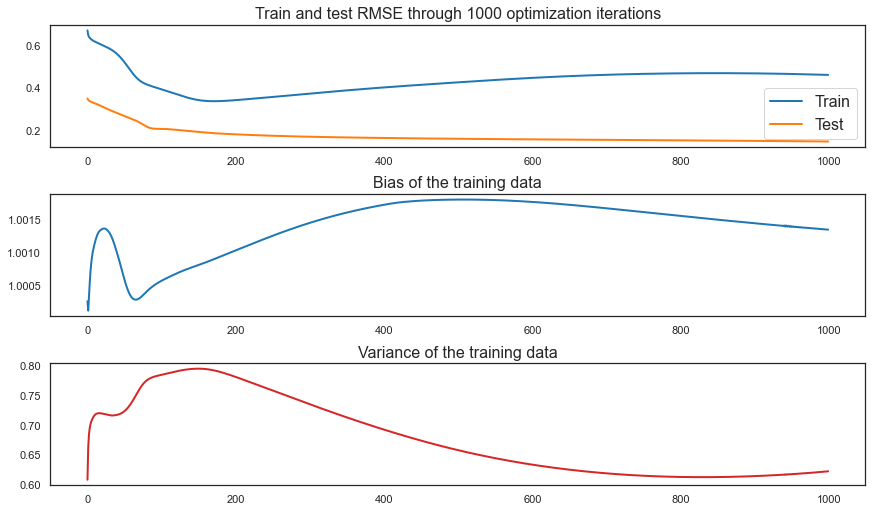

In [38]:
# Plot the evolution of train and test RMSE through the 1000 optimization iterations
fig = plt.figure(constrained_layout=True, figsize=(12, 7))
spec = GridSpec(ncols=1, nrows=3, figure=fig)
ax0 = fig.add_subplot(spec[0, 0])
ax0.plot(rmse, color='tab:blue', label='Train', linewidth=2)
ax0.plot(test_rmse, color='tab:orange', label='Test', linewidth=2)
#ax0.axvline(x=np.where(rmse == rmse.min()), color='red')
ax0.legend(loc='lower right', fontsize=16)
ax0.set_title('Train and test RMSE through 1000 optimization iterations', fontsize=16)

ax1 = fig.add_subplot(spec[1, 0])
ax1.plot(tr_bias, color='tab:blue', label='Bias', linewidth=2)
ax1.set_title('Bias of the training data', fontsize=16)

ax2 = fig.add_subplot(spec[2, 0])
ax2.plot(tr_var, color='tab:red', label='Variance', linewidth=2)
ax2.set_title('Variance of the training data', fontsize=16)

In [39]:
# Train predictions
mean_train, var_train = m.predict_y(X_train)
# Test predictions
mean_test, var_test = m.predict_y(X_test)
# Full predictions (train + test)
# using the trained based normalisation (x_scaler)
mean, var = m.predict_y(x_scaler.transform(X))
_y = y_scaler.transform(y)

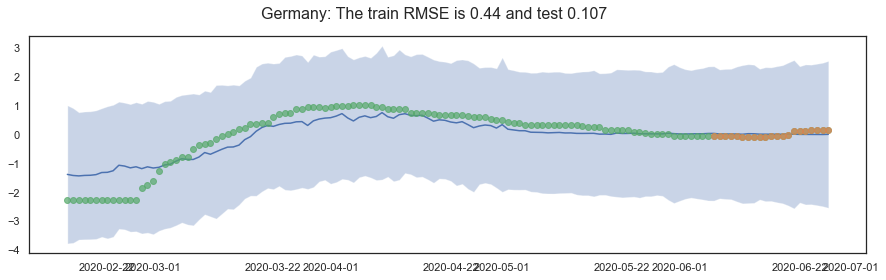

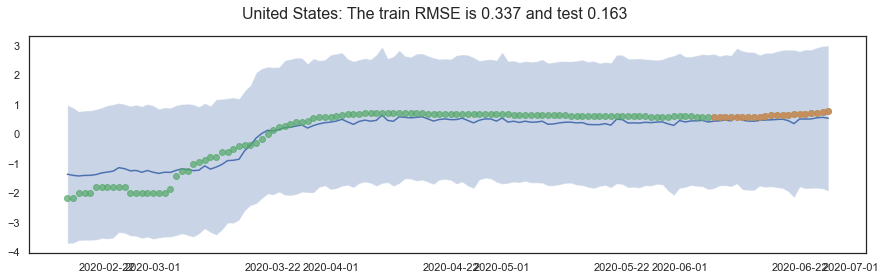

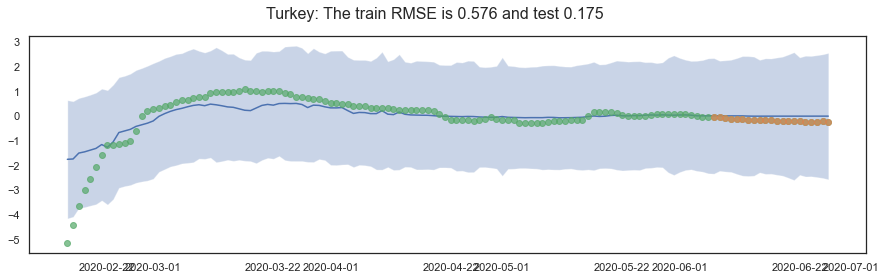

In [40]:
# Results for three countries

countries_list = ["Germany", "United States", "Turkey"]

t = final_data[["Updated_Germany"]].to_numpy()

for c, country in enumerate(countries_list):
    
    train_error = np.sqrt(np.mean((y_train[:, c] - mean_train[:, c])**2))
    test_error = np.sqrt(np.mean((y_test[:, c] - mean_test[:, c])**2))
    
    _fig, ax = plt.subplots(1, figsize=(15, 4))
    
    _fig.suptitle("{0}: The train RMSE is {1} and test {2}".format(country, np.round(train_error, 3), 
                                                                   np.round(test_error, 3)), fontsize=16)
    ax.plot(t, mean[:, c], "-", c="C0")
    lo = (mean[:, c] - 2 * tf.sqrt(var[:, c])).numpy()
    hi = (mean[:, c] + 2 * tf.sqrt(var[:, c])).numpy()
    ax.fill_between(t.flatten(), lo.flatten(), hi.flatten(), alpha=0.3)
    ax.plot(t, _y[:, c], "o", c="C2", alpha=0.7, label="train")
    ax.plot(t[-21:, :], _y[-21:, c], "o", c="C1", alpha=0.7, label="test")

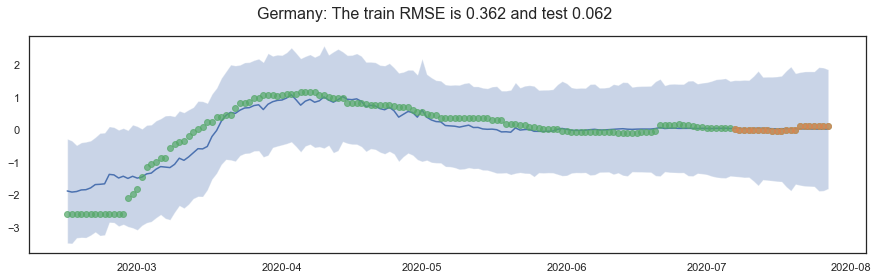

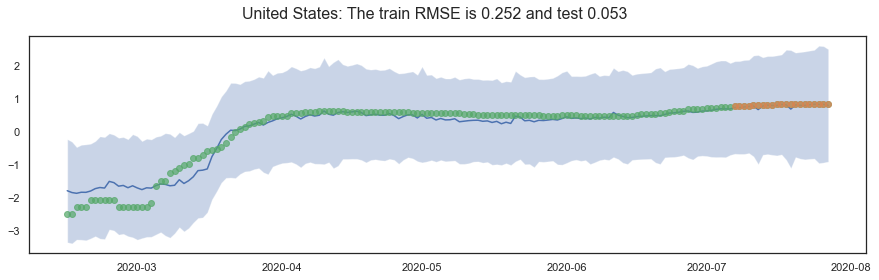

In [28]:
# Results for two countries

countries_list = ["Germany", "United States"]

t = final_data[["Updated_Germany"]].to_numpy()

for c, country in enumerate(countries_list):
    
    train_error = np.sqrt(np.mean((y_train[:, c] - mean_train[:, c])**2))
    test_error = np.sqrt(np.mean((y_test[:, c] - mean_test[:, c])**2))
    
    _fig, ax = plt.subplots(1, figsize=(15, 4))
    
    _fig.suptitle("{0}: The train RMSE is {1} and test {2}".format(country, np.round(train_error, 3), 
                                                                   np.round(test_error, 3)), fontsize=16)
    ax.plot(t, mean[:, c], "-", c="C0")
    lo = (mean[:, c] - 2 * tf.sqrt(var[:, c])).numpy()
    hi = (mean[:, c] + 2 * tf.sqrt(var[:, c])).numpy()
    ax.fill_between(t.flatten(), lo.flatten(), hi.flatten(), alpha=0.3)
    ax.plot(t, _y[:, c], "o", c="C2", alpha=0.7, label="train")
    ax.plot(t[-21:, :], _y[-21:, c], "o", c="C1", alpha=0.7, label="test")